# Lab 3

Lab 3 centers on the photometric analysis of a short-period Cepheid variable star using a sequence of exposures in different filters, as well as associated calibration data.

As before, this notebook will first illustrate some Python features.

In [35]:
import numpy as np
%matplotlib inline
import matplotlib as mpl
import pylab
import sys; sys.path.append('/home/dyson/fall25/180ASTR/Lab3/')
from scipy.interpolate import interp1d
import os
import matplotlib.pyplot as plt
import math
import warnings

from astropy.io import fits
from astropy.time import Time
from scipy.interpolate import UnivariateSpline, PchipInterpolator, interp1d

from a180 import ap_phot
from phot_calcs import find_star_center, detect_trails

# phot_calc.py is located in the vega server at /data/2025-Fall/Lab3/Group4/

## Photometric Analysis of a Cepheid Variable Star

Let's get organized first, and specify our file locations.

We can't save our processed data in the raw data directory; we must specify a different location.  If it doesn't exist, we need to make it first.  You can do this from within Jupyter.  Suppose you want to make a directory called `foo`.  You would open a Terminal and type `mkdir foo`.

In [36]:
raw_data_dir = '/home/dyson/fall25/180ASTR/Lab3/raw/' # directory where raw data are stored
proc_data_dir = '/home/dyson/fall25/180ASTR/Lab3/processed_data/' # place to store our processed data

# dark frames corresponding to the flats
raw_dark_files = []

# flat fields in V and R band
raw_flatV_files = []
raw_flatR_files = []

# sky images in V and R band
raw_skyV_files = []
raw_skyR_files = []

# skies for the photometric standard stars 
raw_photskyV_files = []
raw_photskyR_files = []

# observations of the photometric standard star (Landolt standard)
raw_photV_files = []
raw_photR_files = []

# science target observations in V and R band
raw_targV_files = []
raw_targR_files = []

n = 30
for i in range(1, n + 1):
    if i < 3:
        # flats (1,2)
        raw_flatV_files.append(f'FLAT_V{i}.FIT')
        raw_flatR_files.append(f'FLAT_R{i}.FIT')

    if i < 4:
        # darks (1-3)
        raw_dark_files.append(f'DARK_{i}.FIT')
        
        # sky (1-3)
        raw_skyV_files.append(f'SKYCY_V{i}.FIT')
        raw_skyR_files.append(f'SKYCY_R{i}.FIT')
        raw_photskyV_files.append(f'176SKY_V{i}.FIT')
        raw_photskyR_files.append(f'176SKY_R{i}.FIT')

    if i < 5:
        # calibration images (1-4)
        raw_photV_files.append(f'176_V{i}.FIT')
        raw_photR_files.append(f'176_R{i}.FIT')

    # science images (1-30)
    raw_targV_files.append(f'CYA_V{i}.FIT')
    raw_targR_files.append(f'CYA_R{i}.FIT')

In [38]:
import pandas as pd
from astropy.io import fits
import os

def print_image_log_table(file_lists, descriptions, data_dir=''):
    """
    Create a table of image logs from FITS files.
    
    Parameters:
    -----------
    file_lists : list of lists
        List containing lists of filenames to process
    descriptions : list of str
        List of descriptions for each file list (e.g., 'Dark Frames', 'V-band Flats')
    data_dir : str
        Path to the directory containing the FITS files
    """
    log_data = []
    
    for file_list, desc in zip(file_lists, descriptions):
        for filename in file_list:
            # Add the directory path to the filename
            filepath = os.path.join(data_dir, filename) if data_dir else filename
            
            try:
                with fits.open(filepath) as hdul:
                    header = hdul[0].header
                    
                    # Extract information
                    date_obs = header.get('DATE-OBS', 'N/A')
                    band = header.get('FILTER', 'N/A').strip()
                    
                    # Parse the date-obs to get local time from NOTE if available
                    note = header.get('NOTE', '')
                    if 'Local time:' in note:
                        local_time = note.split('Local time:')[1].strip()
                    else:
                        local_time = 'N/A'
                    
                    log_data.append({
                        'Image Name': filename,
                        'Type': desc,
                        'Band': band,
                        'Local Time': local_time,
                        'Exposure (s)': header.get('EXPTIME', 'N/A')
                    })
            except Exception as e:
                print(f"Error reading {filename}: {e}")
    
    # Create DataFrame and print
    df = pd.DataFrame(log_data)
    if not df.empty:
        print(df.to_string(index=False))
    else:
        print("No data found. Please check your file paths.")
    
    return df

# Usage with your data directory:
raw_data_dir = '/home/dyson/fall25/180ASTR/Lab3/raw/'

file_lists = [
    raw_dark_files,
    raw_flatV_files,
    raw_flatR_files,
    raw_skyV_files,
    raw_skyR_files,
    raw_photskyV_files,
    raw_photskyR_files,
    raw_photV_files,
    raw_photR_files,
    raw_targV_files,
    raw_targR_files
]

descriptions = [
    'Dark Frame',
    'V-band Flat',
    'R-band Flat',
    'V-band Sky',
    'R-band Sky',
    'V-band Phot Sky',
    'R-band Phot Sky',
    'V-band Standard',
    'R-band Standard',
    'V-band Target',
    'R-band Target'
]

# Create and print the table
df = print_image_log_table(file_lists, descriptions, data_dir=raw_data_dir)

# Save to CSV for your report
if not df.empty:
    df.to_csv('observation_log.csv', index=False)
    print("\nTable saved to 'observation_log.csv'")

   Image Name            Type Band                 Local Time  Exposure (s)
   DARK_1.FIT      Dark Frame    r 10/27/2025 at 22:27:43.000          30.0
   DARK_2.FIT      Dark Frame    V 10/27/2025 at 22:25:21.000          30.0
   DARK_3.FIT      Dark Frame    V 10/27/2025 at 22:26:29.000          30.0
  FLAT_V1.FIT     V-band Flat    V 10/27/2025 at 22:20:34.000          30.0
  FLAT_V2.FIT     V-band Flat    V 10/27/2025 at 22:21:43.000          30.0
  FLAT_R1.FIT     R-band Flat    r 10/27/2025 at 22:17:42.000          30.0
  FLAT_R2.FIT     R-band Flat    r 10/27/2025 at 22:19:02.000          30.0
 SKYCY_V1.FIT      V-band Sky    V 10/27/2025 at 19:53:52.000          30.0
 SKYCY_V2.FIT      V-band Sky    V 10/27/2025 at 19:55:59.000          30.0
 SKYCY_V3.FIT      V-band Sky    V 10/27/2025 at 21:34:43.000          30.0
 SKYCY_R1.FIT      R-band Sky    r 10/27/2025 at 19:57:15.000          30.0
 SKYCY_R2.FIT      R-band Sky    r 10/27/2025 at 19:58:23.000          30.0
 SKYCY_R3.FI

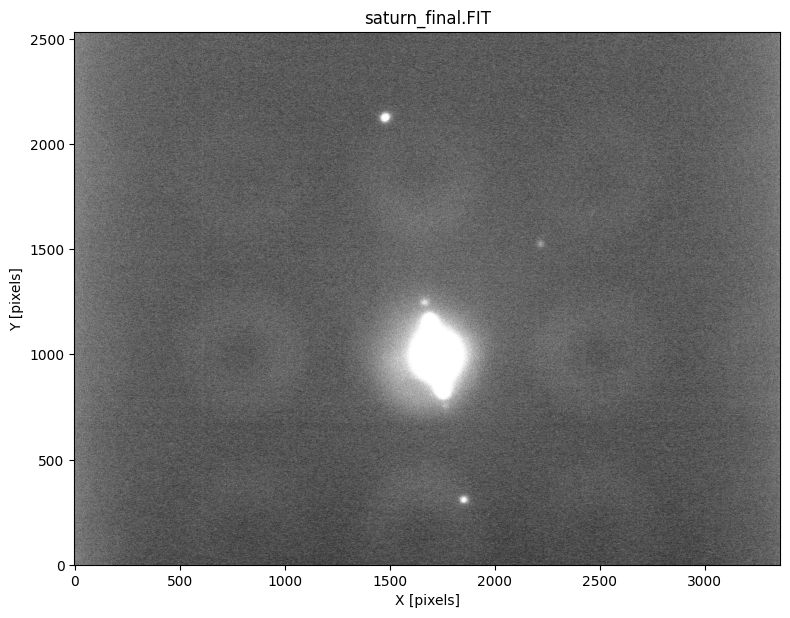

Image shape: (2536, 3358)
Data type: uint16
Min value: 0
Max value: 65535
Mean value: 1101.56


In [3]:
# Load the Saturn image
saturn_file = os.path.join(raw_data_dir, 'saturn_final.FIT')
saturn_data = fits.getdata(saturn_file)

# Create figure
fig, ax = plt.subplots(figsize=(8, 8))

# Display the image with appropriate scaling
ax.imshow(saturn_data, cmap='gray', origin='lower',
          vmin=np.percentile(saturn_data, 1),
          vmax=np.percentile(saturn_data, 99))
ax.set_title('saturn_final.FIT')
ax.set_xlabel('X [pixels]')
ax.set_ylabel('Y [pixels]')

plt.tight_layout()
plt.show()

# Print some basic info
print(f"Image shape: {saturn_data.shape}")
print(f"Data type: {saturn_data.dtype}")
print(f"Min value: {np.min(saturn_data)}")
print(f"Max value: {np.max(saturn_data)}")
print(f"Mean value: {np.mean(saturn_data):.2f}")

### Calibrating the data

We'll need to calibrate our data.  For our target star images, we'll need to subtract out the background light using our sky exposures, as well as divide by the response function (the "flat field").

#### Creating the flat fields in each band

For each band ($V$ and $R$), we must first construct the flat field; this is done by removing the expected bias and dark current levels.

We're going to be loading and combining files fiarly often in our calibrations, so lets define a load and combine function.  We'll use median combination rather than averaging since it is more robust to errors that come from cosmic rays.

Let's first apply it to the dark exposure.

In [4]:
def load_and_combine(filenames, prefix=''):
    "Load and use median combination on a list of exposures.  Returns a numpy array."
    images = [] # define an empty list
    for fn in filenames:
        images.append(fits.getdata(prefix+fn)) # populate the list with image arrays from each file
    images = np.array(images) # turn the list into a 3d numpy array
    combined_im = np.median(images, axis=0) # use median combination along the first axis (image index)
    return combined_im

In [5]:
# process dark
dark_im = load_and_combine(raw_dark_files, prefix=raw_data_dir) # load and combine dark exposures into a dark frame
dark_fn = 'dark.fits' # filename for our combined dark frame
fits.writeto(proc_data_dir+dark_fn, dark_im, overwrite=True) # store the combined dark frame in a FITS file

Now that we have a dark exposure, we can create the flat fields.

In a given band, we will load and combine the flat field exposures.  We will subtract out the dark frame, and then normalize by the median value so that the flat field frame represents a relative response level.  We can then save it to file.

In [6]:
# Create V-band flat field
flatV_im = load_and_combine(raw_flatV_files, prefix=raw_data_dir) - dark_im  # subtract dark frame
flatV_im /= np.median(flatV_im)  # normalize by median value
flatV_fn = 'flatV.fits'
fits.writeto(proc_data_dir + flatV_fn, flatV_im, overwrite=True)  # save combined V-band flat field

# Create R-band flat field
flatR_im = load_and_combine(raw_flatR_files, prefix=raw_data_dir) - dark_im  # subtract dark frame
flatR_im /= np.median(flatR_im)  # normalize by median value
flatR_fn = 'flatR.fits'
fits.writeto(proc_data_dir + flatR_fn, flatR_im, overwrite=True)  # save combined R-band flat field

#### Processing sky exposures

We won't have to do anything fancy to the sky background exposures, just load them and combine them for each set.

In [7]:
# process and store sky exposures for target, V band
skyV_im = load_and_combine(raw_skyV_files, prefix=raw_data_dir)  # combine target sky V-band frames
skyV_fn = 'sky_target_V.fits'
fits.writeto(proc_data_dir + skyV_fn, skyV_im, overwrite=True)

# process and store sky exposures for target, R band
skyR_im = load_and_combine(raw_skyR_files, prefix=raw_data_dir)  # combine target sky R-band frames
skyR_fn = 'sky_target_R.fits'
fits.writeto(proc_data_dir + skyR_fn, skyR_im, overwrite=True)

# process and store sky exposures for photometric standard, V band
phot_skyV_im = load_and_combine(raw_photskyV_files, prefix=raw_data_dir)  # combine photometric sky V-band frames
phot_skyV_fn = 'sky_photV.fits'
fits.writeto(proc_data_dir + phot_skyV_fn, phot_skyV_im, overwrite=True)

# process and store sky exposures for photometric standard, R band
phot_skyR_im = load_and_combine(raw_photskyR_files, prefix=raw_data_dir)  # combine photometric sky R-band frames
phot_skyR_fn = 'sky_photR.fits'
fits.writeto(proc_data_dir + phot_skyR_fn, phot_skyR_im, overwrite=True)

#### Calibrating photometric exposures

We have several data sets we need to calibrate, namely our target and photometric standard star exposures in each filter band.

To do this, we'll load each exposure, subtract the sky background, and divide by the flat field response.  We'll store the output as a file.  Let's try to simplify the process by writing a function.

In [8]:
def process_photometry(raw_filename, sky_im, flat_im, raw_dir='', out_dir='', prefix='proc-'):
    "Calibrate a photometric exposure"
    out_fn = prefix + raw_filename
    im = fits.getdata(raw_dir + raw_filename)
    
    # Calibration steps: subtract sky, divide by flat
    # Suppress warnings about division by zero/invalid values
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)
        proc_im = (im - sky_im) / flat_im
    
    # Replace any NaN or inf values with zero (these are bad pixels anyway)
    proc_im = np.nan_to_num(proc_im, nan=0.0, posinf=0.0, neginf=0.0)
    
    fits.writeto(out_dir + out_fn, proc_im, overwrite=True)
    return out_fn

Flat V-band statistics:
  Shape: (2536, 3358)
  Min: -0.6601873300433074
  Max: 3.163460570047336
  Mean: 1.0247967824751179
  Number of zeros: 17
  Number of NaNs: 0
  Number < 0.1: 20

Flat R-band statistics:
  Shape: (2536, 3358)
  Min: 0.0
  Max: 1.2875751503006012
  Mean: 1.0108757053411948
  Number of zeros: 17
  Number of NaNs: 0
  Number < 0.1: 23


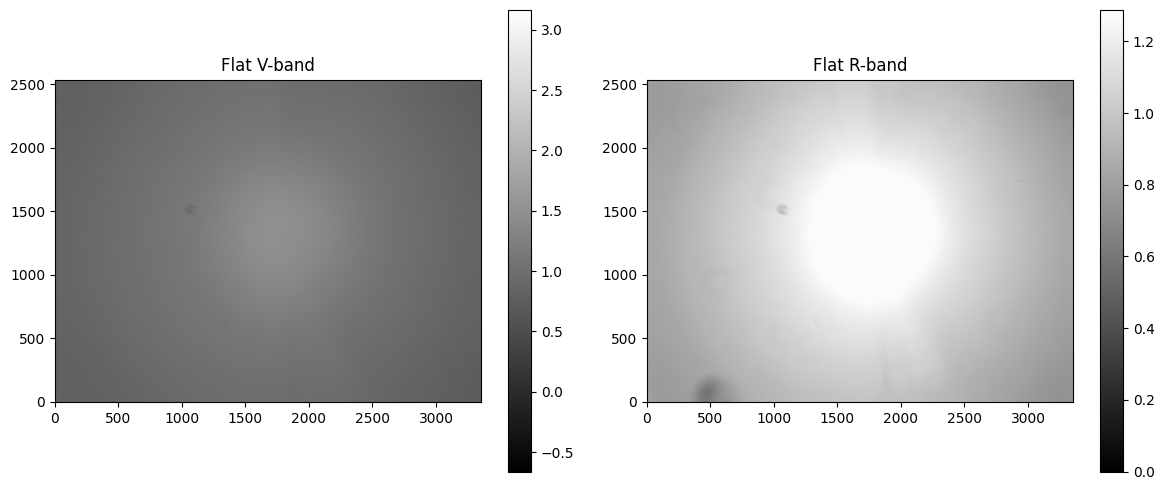

In [9]:
# Check the flat field
print("Flat V-band statistics:")
print(f"  Shape: {flatV_im.shape}")
print(f"  Min: {np.min(flatV_im)}")
print(f"  Max: {np.max(flatV_im)}")
print(f"  Mean: {np.mean(flatV_im)}")
print(f"  Number of zeros: {np.sum(flatV_im == 0)}")
print(f"  Number of NaNs: {np.sum(np.isnan(flatV_im))}")
print(f"  Number < 0.1: {np.sum(flatV_im < 0.1)}")

print("\nFlat R-band statistics:")
print(f"  Shape: {flatR_im.shape}")
print(f"  Min: {np.min(flatR_im)}")
print(f"  Max: {np.max(flatR_im)}")
print(f"  Mean: {np.mean(flatR_im)}")
print(f"  Number of zeros: {np.sum(flatR_im == 0)}")
print(f"  Number of NaNs: {np.sum(np.isnan(flatR_im))}")
print(f"  Number < 0.1: {np.sum(flatR_im < 0.1)}")

# Visualize the flat field to see where the problem areas are
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im0 = axes[0].imshow(flatV_im, cmap='gray', origin='lower')
axes[0].set_title('Flat V-band')
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(flatR_im, cmap='gray', origin='lower')
axes[1].set_title('Flat R-band')
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()


In [10]:
# process photometric standard exposures, V band
proc_photV_files = []
for fn in raw_photV_files:
    proc_fn = process_photometry(fn, phot_skyV_im, flatV_im, 
                                 raw_data_dir, 
                                 proc_data_dir)
    proc_photV_files.append(proc_fn)

# process photometric standard exposures, R band
proc_photR_files = []
for fn in raw_photR_files:
    proc_fn = process_photometry(fn, phot_skyR_im, flatR_im, 
                                 raw_dir=raw_data_dir, 
                                 out_dir=proc_data_dir)
    proc_photR_files.append(proc_fn)

# process target star exposures, V band
proc_targV_files = []
for fn in raw_targV_files:
    proc_fn = process_photometry(fn, skyV_im, flatV_im, 
                                 raw_dir=raw_data_dir, 
                                 out_dir=proc_data_dir)
    proc_targV_files.append(proc_fn)

# process target star exposures, R band
proc_targR_files = []
for fn in raw_targR_files:
    proc_fn = process_photometry(fn, skyR_im, flatR_im, 
                                 raw_dir=raw_data_dir, 
                                 out_dir=proc_data_dir)
    proc_targR_files.append(proc_fn)

Now all our data have had the first level of calibration performed, and we're ready to start making photometric measurements.

### Getting uncalibrated photometry

We need to add up the light from our measurements.  This will give us uncalibrated photometry, in units of DN/s.

To do this we'll define an "aperture," which is a virtual region in the image over which we'll add up the counts.  This will be a circular aperture centered on the star.

We also expect that our sky background subtraction is not perfect, so we'll define a "sky annulus," a ring-like region outside of our photometric aperture over which the residual sky level will be determiend and subtracted from our target aperture.

So we'll need to find:
* star center in pixel coordinates
* radius of the photometric aperture
* inner and outer radii of the sky annulus

To simplify the analysis, we'll use the same aperture parameters on all exposures.  That way we only have to find the stellar centers in each exposure.

Let's start with an example exposure.

#### Example exposure photometry

Let's load and display an example exposure.  We'll overlay the photometric and sky annulus apertures on the image to check consistency, and we'll get the photometric measurement.

We should be sure the apertures are centered on the star.

The ideal size for the photometric aperture is roughly to have it as large as possible without being so big as being dominated by sky background noise.  So we should have it sized so that it encompasses the majority of the visible starlight.

Note that since we are using the same aperture sizes for all exposures, it won't be optimal in all cases.  We're aiming for "good enough" here.

The sky annulus inner radius should be large enough so that no signal from the star is in the sky annulus.  The outer radius should be large enough so that a good number of pixels are included (ideally more area in the sky annulus than the target aperture), but not so large that systematic errors from sky nonuniformity creep in.  There is no grea recipe for the sky annulus; just get something good enough.

Once we have our aperture set, let's do the photometry.

In [11]:
flatV1 = fits.getdata(os.path.join(raw_data_dir, 'FLAT_V1.FIT')).astype(float)
flatV2 = fits.getdata(os.path.join(raw_data_dir, 'FLAT_V2.FIT')).astype(float)
flatR1 = fits.getdata(os.path.join(raw_data_dir, 'FLAT_R1.FIT')).astype(float)
flatR2 = fits.getdata(os.path.join(raw_data_dir, 'FLAT_R2.FIT')).astype(float)

dark1 = fits.getdata(os.path.join(raw_data_dir, 'DARK_1.FIT')).astype(float)
dark2 = fits.getdata(os.path.join(raw_data_dir, 'DARK_2.FIT')).astype(float)

gainV = ((np.mean(flatV1) + np.mean(flatV2)) - (np.mean(dark1) + np.mean(dark2))) / \
        (np.var(flatV1 - flatV2) - np.var(dark1 - dark2))

gainR = ((np.mean(flatR1) + np.mean(flatR2)) - (np.mean(dark1) + np.mean(dark2))) / \
        (np.var(flatR1 - flatR2) - np.var(dark1 - dark2))
print("GainV =", gainV, "e-/DN")
print("GainR =", gainR, "e-/DN")





GainV = 0.3806225801199869 e-/DN
GainR = 0.34881623902860226 e-/DN


Calculating the gain instead of getting it from header barely changed the values

It doesn't seem to change the measured mag (at least to 7 decimals)

It only changes the error in R mag by ~0.0000243

#### Positions for all star exposures

We need to get the star position for all of our exposures.  The simplest way is through visual inspection.

#### This section uses find_star_center

In [12]:
# Find positions for all target V-band exposures (already sky-subtracted)
CY_radV = 0
targV_xys = []
for i, fn in enumerate(proc_targV_files):
    im = fits.getdata(proc_data_dir + fn)
    x, y, temp = find_star_center(im)
    targV_xys.append((x, y))
    CY_radV += temp

CY_radV = math.ceil(CY_radV / np.size(proc_targV_files))

# Find positions for all target R-band exposures (already sky-subtracted)
CY_radR = 0
targR_xys = []
for i, fn in enumerate(proc_targR_files):
    im = fits.getdata(proc_data_dir + fn)
    x, y, temp = find_star_center(im)
    targR_xys.append((x, y))
    CY_radR += temp

CY_radR = math.ceil(CY_radR / np.size(proc_targR_files))

# Find positions for all standard V-band exposures (already sky-subtracted)
std_radV = 0
stdV_xys = []
for i, fn in enumerate(proc_photV_files):
    im = fits.getdata(proc_data_dir + fn)
    x, y, temp = find_star_center(im)
    stdV_xys.append((x, y))
    std_radV += temp

std_radV = math.ceil(std_radV / np.size(proc_photV_files))

# Find positions for all standard R-band exposures (already sky-subtracted)
std_radR = 0
stdR_xys = []
for i, fn in enumerate(proc_photR_files):
    im = fits.getdata(proc_data_dir + fn)
    x, y, temp = find_star_center(im)
    stdR_xys.append((x, y))
    std_radR += temp

std_radR = math.ceil(std_radR / np.size(proc_photR_files))

print(std_radV, ' ', std_radR, ' ', CY_radV, ' ', CY_radR)

23   36   22   25


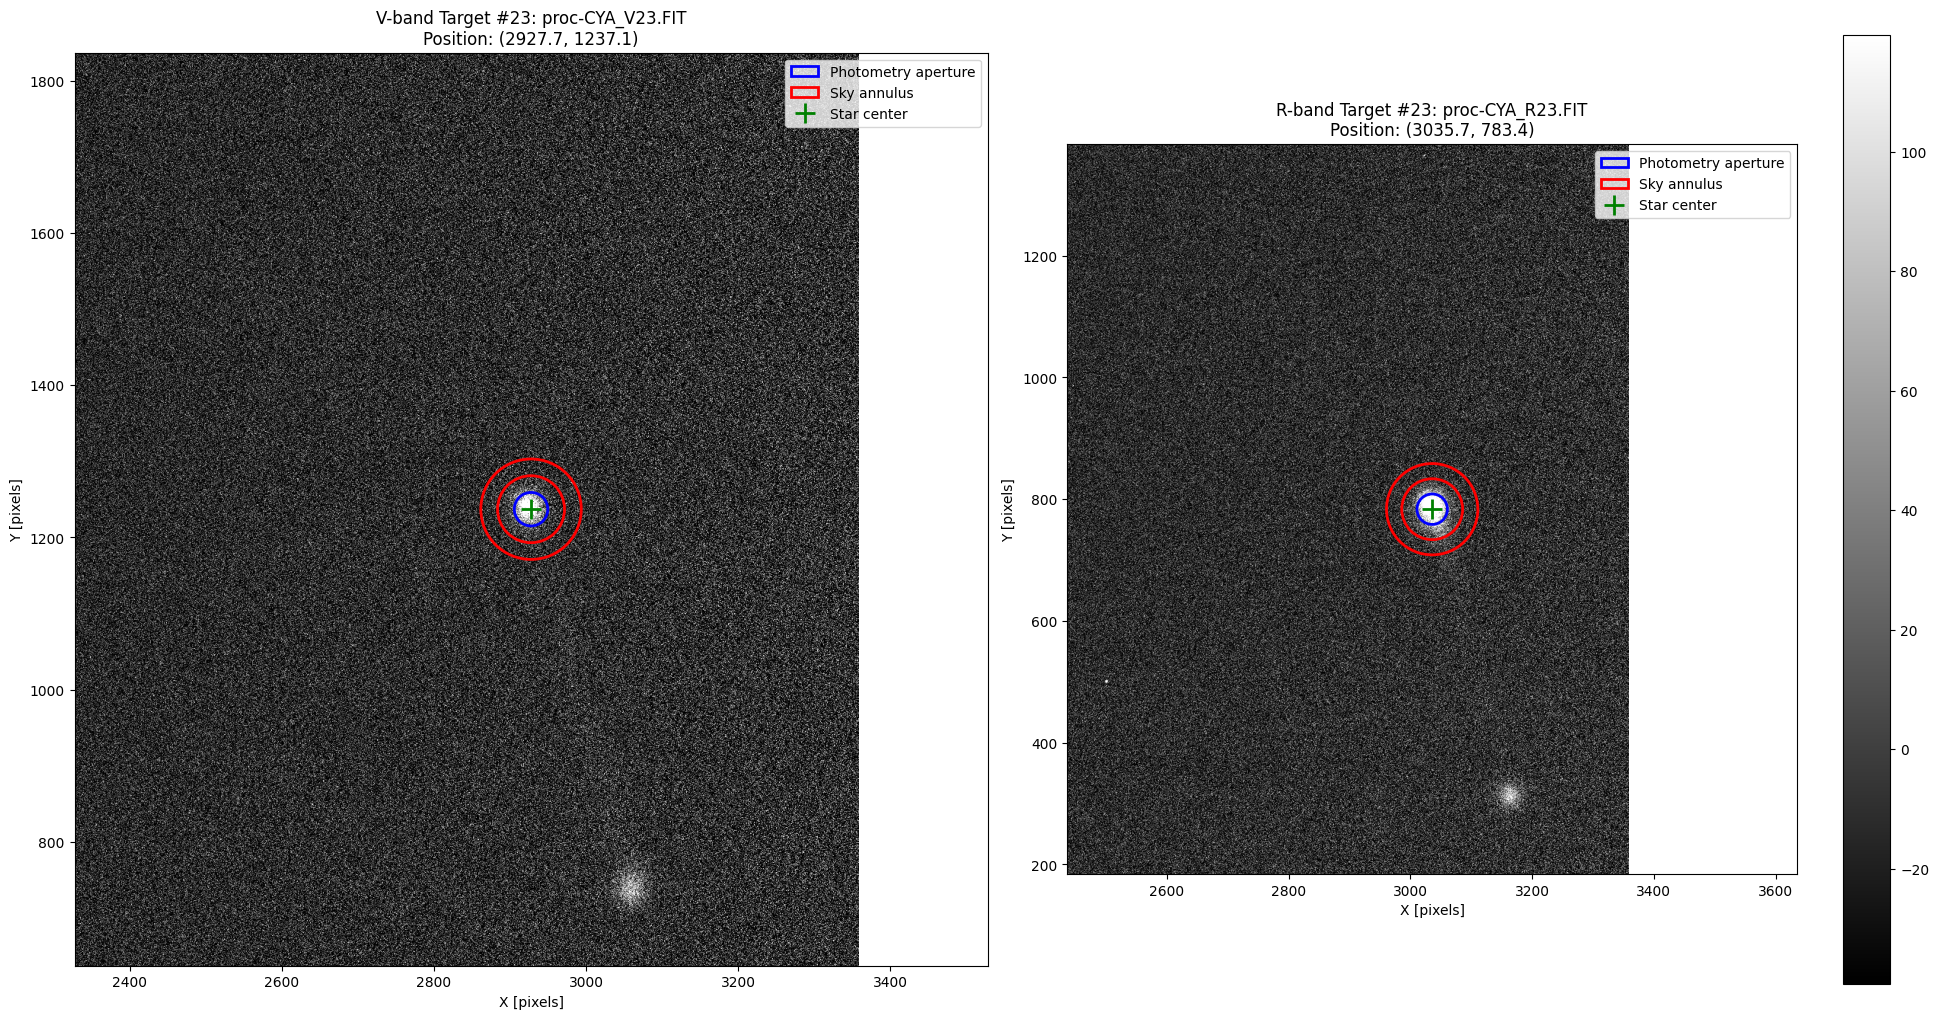

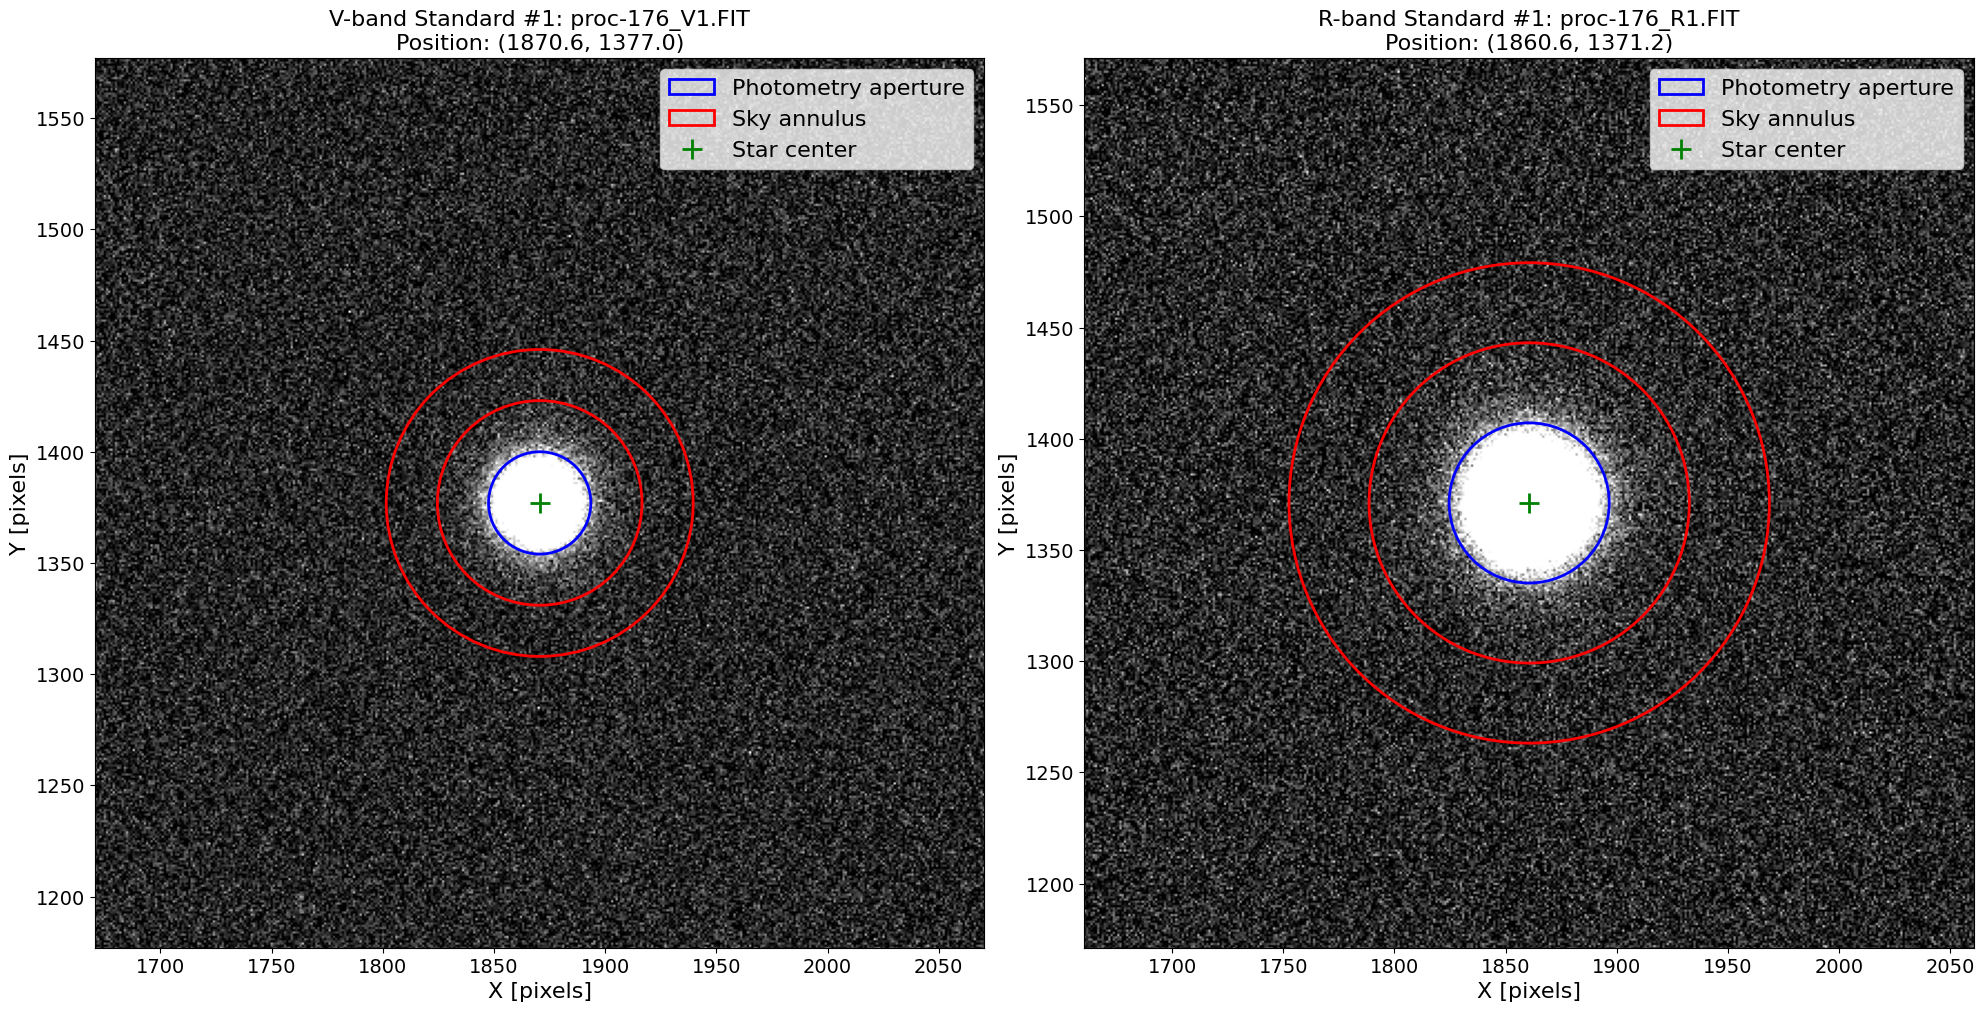

In [13]:
# Display target star images with apertures (V and R side-by-side)
for i in range(22, 23): # this range shows the images where the target shifted during the exposure
#for i in range(min(3, len(proc_targV_files))):
    # Load both V and R images
    im_V = fits.getdata(proc_data_dir + proc_targV_files[i])
    im_R = fits.getdata(proc_data_dir + proc_targR_files[i])
    
    x_V, y_V = targV_xys[i]
    x_R, y_R = targR_xys[i]
    
    # Create figure with two subplots
    fig, (ax1, ax2) = pylab.subplots(1, 2, figsize=(20, 10))
    
    # V-band image
    vmin_V, vmax_V = np.percentile(im_V[np.isfinite(im_V)], [30, 99.9])
    ax1.imshow(im_V, cmap='gray', origin='lower', vmin=vmin_V, vmax=vmax_V)
    
    # V-band apertures
    sky_ann_inner_V = CY_radV * 2
    sky_ann_outer_V = CY_radV * 3
    
    ax1.add_patch(mpl.patches.Circle((x_V, y_V), radius=CY_radV,
                                     ec='b', linewidth=2, fill=False, label='Photometry aperture'))
    ax1.add_patch(mpl.patches.Circle((x_V, y_V), radius=sky_ann_inner_V,
                                     ec='r', linewidth=2, fill=False, label='Sky annulus'))
    ax1.add_patch(mpl.patches.Circle((x_V, y_V), radius=sky_ann_outer_V,
                                     ec='r', linewidth=2, fill=False))
    ax1.plot(x_V, y_V, 'g+', markersize=15, markeredgewidth=2, label='Star center')
    
    ax1.set_title(f'V-band Target #{i+1}: {proc_targV_files[i]}\nPosition: ({x_V:.1f}, {y_V:.1f})')
    ax1.set_xlabel('X [pixels]')
    ax1.set_ylabel('Y [pixels]')
    ax1.legend()
    
    zoom_size = 600
    ax1.set_xlim(x_V - zoom_size, x_V + zoom_size)
    ax1.set_ylim(y_V - zoom_size, y_V + zoom_size)
    
    # R-band image
    vmin_R, vmax_R = np.percentile(im_R[np.isfinite(im_R)], [30, 99.9])
    a = ax2.imshow(im_R, cmap='gray', origin='lower', vmin=vmin_R, vmax=vmax_R)
    
    # R-band apertures
    sky_ann_inner_R = CY_radR * 2
    sky_ann_outer_R = CY_radR * 3
    
    ax2.add_patch(mpl.patches.Circle((x_R, y_R), radius=CY_radR,
                                     ec='b', linewidth=2, fill=False, label='Photometry aperture'))
    ax2.add_patch(mpl.patches.Circle((x_R, y_R), radius=sky_ann_inner_R,
                                     ec='r', linewidth=2, fill=False, label='Sky annulus'))
    ax2.add_patch(mpl.patches.Circle((x_R, y_R), radius=sky_ann_outer_R,
                                     ec='r', linewidth=2, fill=False))
    ax2.plot(x_R, y_R, 'g+', markersize=15, markeredgewidth=2, label='Star center')
    
    ax2.set_title(f'R-band Target #{i+1}: {proc_targR_files[i]}\nPosition: ({x_R:.1f}, {y_R:.1f})')
    ax2.set_xlabel('X [pixels]')
    ax2.set_ylabel('Y [pixels]')
    ax2.legend()
    
    ax2.set_xlim(x_R - zoom_size, x_R + zoom_size)
    ax2.set_ylim(y_R - zoom_size, y_R + zoom_size)
    
    fig.colorbar(a)
    pylab.tight_layout()
    pylab.show()
    

# Display standard star images with apertures (V and R side-by-side)
for i in range(min(1, len(proc_photV_files))):
    # Load both V and R images
    im_V = fits.getdata(proc_data_dir + proc_photV_files[i])
    im_R = fits.getdata(proc_data_dir + proc_photR_files[i])
    
    x_V, y_V = stdV_xys[i]
    x_R, y_R = stdR_xys[i]
    
    # Create figure with two subplots
    fig, (ax1, ax2) = pylab.subplots(1, 2, figsize=(20, 10))
    
    # V-band image
    vmin_V, vmax_V = np.percentile(im_V[np.isfinite(im_V)], [30, 99.9])
    ax1.imshow(im_V, cmap='gray', origin='lower', vmin=vmin_V, vmax=vmax_V)
    
    # V-band apertures
    sky_ann_inner_V = std_radV * 2
    sky_ann_outer_V = std_radV * 3
    
    ax1.add_patch(mpl.patches.Circle((x_V, y_V), radius=std_radV,
                                     ec='b', linewidth=2, fill=False, label='Photometry aperture'))
    ax1.add_patch(mpl.patches.Circle((x_V, y_V), radius=sky_ann_inner_V,
                                     ec='r', linewidth=2, fill=False, label='Sky annulus'))
    ax1.add_patch(mpl.patches.Circle((x_V, y_V), radius=sky_ann_outer_V,
                                     ec='r', linewidth=2, fill=False))
    ax1.plot(x_V, y_V, 'g+', markersize=15, markeredgewidth=2, label='Star center')
    
    ax1.set_title(f'V-band Standard #{i+1}: {proc_photV_files[i]}\nPosition: ({x_V:.1f}, {y_V:.1f})', fontsize=16)
    ax1.set_xlabel('X [pixels]', fontsize=16)
    ax1.set_ylabel('Y [pixels]', fontsize=16)
    ax1.legend(fontsize=16)
    ax1.tick_params(axis='both', labelsize=14)
    
    zoom_size = 200
    ax1.set_xlim(x_V - zoom_size, x_V + zoom_size)
    ax1.set_ylim(y_V - zoom_size, y_V + zoom_size)
    
    # R-band image
    vmin_R, vmax_R = np.percentile(im_R[np.isfinite(im_R)], [30, 99.9])
    ax2.imshow(im_R, cmap='gray', origin='lower', vmin=vmin_R, vmax=vmax_R)
    
    # R-band apertures
    sky_ann_inner_R = std_radR * 2
    sky_ann_outer_R = std_radR * 3
    
    ax2.add_patch(mpl.patches.Circle((x_R, y_R), radius=std_radR,
                                     ec='b', linewidth=2, fill=False, label='Photometry aperture'))
    ax2.add_patch(mpl.patches.Circle((x_R, y_R), radius=sky_ann_inner_R,
                                     ec='r', linewidth=2, fill=False, label='Sky annulus'))
    ax2.add_patch(mpl.patches.Circle((x_R, y_R), radius=sky_ann_outer_R,
                                     ec='r', linewidth=2, fill=False))
    ax2.plot(x_R, y_R, 'g+', markersize=15, markeredgewidth=2, label='Star center')
    
    ax2.set_title(f'R-band Standard #{i+1}: {proc_photR_files[i]}\nPosition: ({x_R:.1f}, {y_R:.1f})', fontsize=16)
    ax2.set_xlabel('X [pixels]', fontsize=16)
    ax2.set_ylabel('Y [pixels]', fontsize=16)
    ax2.legend(fontsize=16)
    ax2.tick_params(axis='both', labelsize=14)
    
    ax2.set_xlim(x_R - zoom_size, x_R + zoom_size)
    ax2.set_ylim(y_R - zoom_size, y_R + zoom_size)
    
    pylab.tight_layout()
    fig.savefig('proc-176_V1.pdf', dpi=600, bbox_inches='tight')
    pylab.show()

#### Photometry for all exposures

Let's loop and get photometric measurements for all exposures.  Try writing a function to loop over an exposure sequence, and return numpy arrays of the photometry and photometric error, each in DN/s.

In [14]:
# Extract time offsets from FITS headers for V band
t_offs_V = []
t_start_V = None
for fn in raw_targV_files:  # Use raw files since they have the original headers
    path = os.path.join(raw_data_dir, fn)
    with fits.open(path) as hdul:
        header = hdul[0].header
        date_obs = header.get("DATE-OBS")
        if date_obs:
            exptime = header.get("EXPTIME", "N/A")
            obs_time = Time(date_obs, format='isot')
            if t_start_V is None:
                t_start_V = obs_time
            t_offs_V.append((obs_time - t_start_V).sec)
        else:
            print(f"Warning: No DATE-OBS in {fn}")
            
# Extract time offsets from FITS headers for R band
t_offs_R = []
t_start_R = None
for fn in raw_targR_files:  # Use raw files since they have the original headers
    path = os.path.join(raw_data_dir, fn)
    with fits.open(path) as hdul:
        header = hdul[0].header
        date_obs = header.get("DATE-OBS")
        if date_obs:
            obs_time = Time(date_obs, format='isot')
            if t_start_R is None:
                t_start_R = obs_time
            t_offs_R.append((obs_time - t_start_R).sec)
        else:
            print(f"Warning: No DATE-OBS in {fn}")

In [15]:
def get_dns(gain, image_files, positions, radius, t_exp):
    """
    Perform aperture photometry on a sequence of images.
    
    Parameters:
    -----------
    gain : float
        Gain of the detector [e-/DN]
    image_files : list
        List of image filenames
    positions : list of tuples
        List of (x, y) positions for each image
    radius : float
        Photometric aperture radius [pixels]
    t_exp : float
        Exposure time [seconds]
    
    Returns:
    --------
    F : numpy array
        Photometry measurements [DN/s]
    F_err : numpy array
        Photometry uncertainties [DN/s]
    """
    # Calculate sky annulus radii based on photometric aperture
    sky_inner = radius * 2
    sky_outer = radius * 3
    
    F = np.zeros(len(image_files))
    F_err = np.zeros(len(image_files))
    
    for i, (fn, (x, y)) in enumerate(zip(image_files, positions)):
        # Load the image
        im = fits.getdata(proc_data_dir + fn)
        
        # Perform aperture photometry
        phot, phot_err = ap_phot(im, x, y, 
                                 radius, 
                                 sky_in=sky_inner, 
                                 sky_out=sky_outer, 
                                 gain=gain)
        
        F[i] = phot
        F_err[i] = phot_err
    
    # Convert from DN to DN/s
    F /= t_exp
    F_err /= t_exp
    
    return F, F_err

In [16]:
# Get photometry for all target V-band images (uses CY_radV)
F_V_targ, F_V_targ_err = get_dns(gainV, proc_targV_files, targV_xys, CY_radV, exptime)

# Get photometry for all target R-band images (uses CY_radR)
F_R_targ, F_R_targ_err = get_dns(gainR, proc_targR_files, targR_xys, CY_radR, exptime)

# Get photometry for all standard V-band images (uses std_radV)
F_V_std, F_V_std_err = get_dns(gainV, proc_photV_files, stdV_xys, std_radV, exptime)

# Get photometry for all standard R-band images (uses std_radR)
F_R_std, F_R_std_err = get_dns(gainR, proc_photR_files, stdR_xys, std_radR, exptime)

#### Plotting the raw photometry vs. time

Let's do a quick check and examine our photometry (and errors) vs. time in each band.

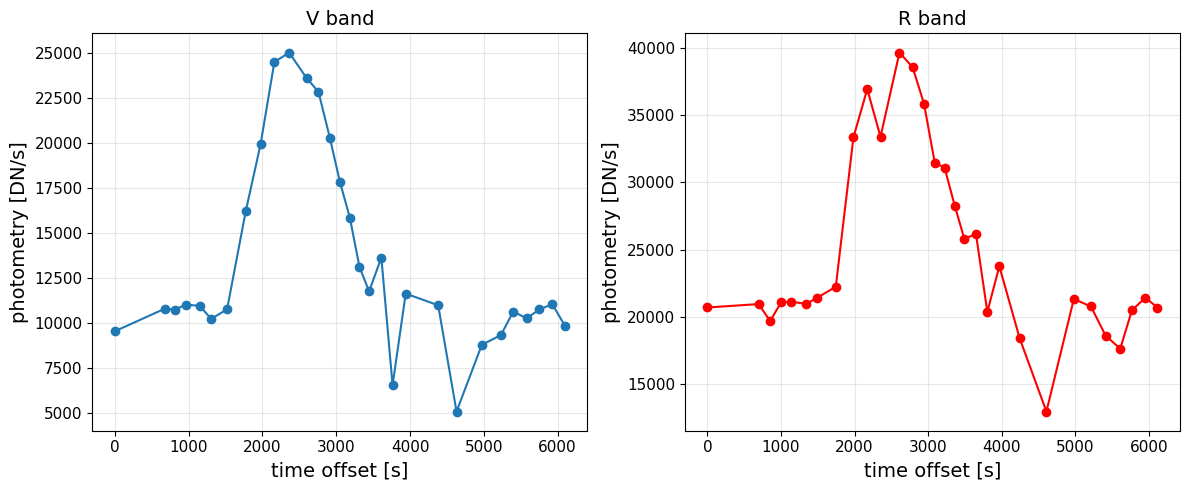

In [17]:
# Convert to numpy arrays
t_offs_V = np.array(t_offs_V)
t_offs_R = np.array(t_offs_R)

# set up figure
fig = pylab.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121) # one row, two columns, first subplot
ax2 = fig.add_subplot(122) # one row, two columns, second subplot

# plot V band
ax1.errorbar(t_offs_V, F_V_targ, F_V_targ_err, fmt='o-')
ax1.set_title('V band', fontsize=14)
ax1.set_xlabel('time offset [s]', fontsize=14)
ax1.set_ylabel('photometry [DN/s]', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='both', labelsize=11)

# plot R band
ax2.errorbar(t_offs_R, F_R_targ, F_R_targ_err, fmt='o-', color='red')
ax2.set_title('R band', fontsize=14)
ax2.set_xlabel('time offset [s]', fontsize=14)
ax2.set_ylabel('photometry [DN/s]', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='both', labelsize=11)

# finalize plot
pylab.tight_layout()
fig.savefig('flux_time.pdf', dpi=600, bbox_inches='tight')
pylab.show()

#### Calibrating the photometry

We'll use the standard star photometry and its known magnitudes in each filter to calibrate our starget star photometry and put it into magnitude units.

Let's first get an average DN/s level for our standard star in each band, along with an uncertainty.  

In [18]:
F0_V = np.mean(F_V_std)  # [DN/s]
F0_V_err = np.std(F_V_std) / np.sqrt(len(F_V_std))  # [DN/s] - standard error of the mean
F0_R = np.mean(F_R_std)  # [DN/s]
F0_R_err = np.std(F_R_std) / np.sqrt(len(F_R_std))  # [DN/s] - standard error of the mean

print(f"Standard star V-band: {F0_V:.2f} ± {F0_V_err:.2f} DN/s")
print(f"Standard star R-band: {F0_R:.2f} ± {F0_R_err:.2f} DN/s")

Standard star V-band: 19145.03 ± 484.03 DN/s
Standard star R-band: 122210.62 ± 780.01 DN/s


### The second use of the module I made

σ of 3.8 was chosen slightly arbitrarily as it was the minimum needed to exclude the images that had lithering during the exposure


Checking V-band images for star trails...
STAR TRAIL DETECTION (Modified Z-Score)
Threshold: 3.8 modified z-score (below median only)
Median flux: 11012.3 DN/s
MAD (negative deviations): 747.3 DN/s
Equivalent sigma: 1107.9 DN/s


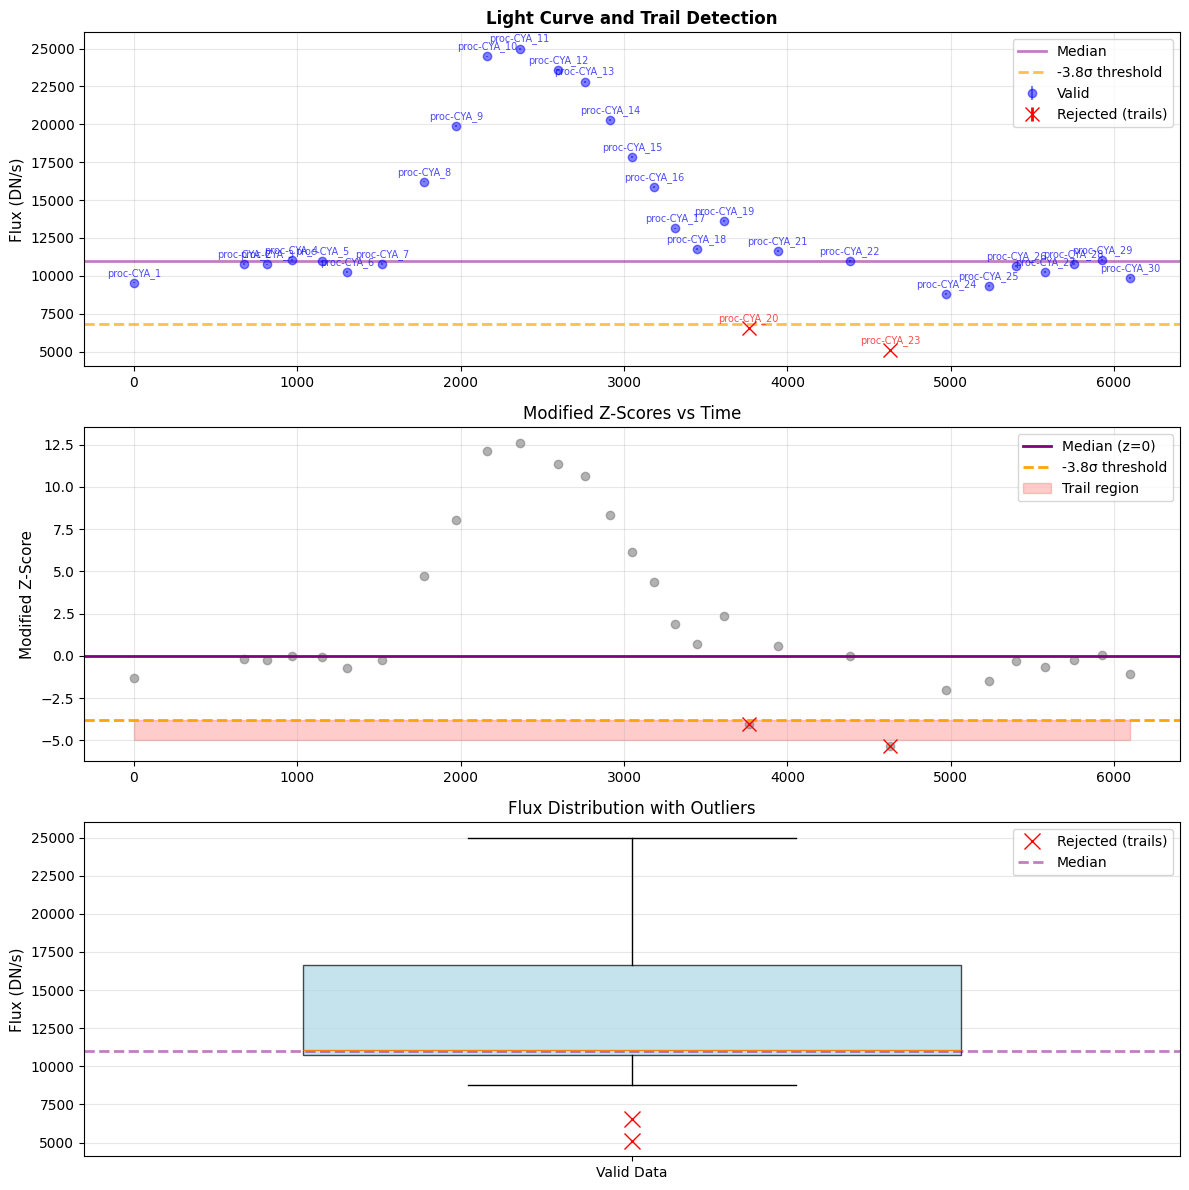

    TRAIL DETECTED in proc-CYA_V20.FIT:
      Measured flux: 6564.9 DN/s
      Median flux: 11012.3 DN/s
      Modified Z-Score: -4.01
      Time: 3763.0 s
    TRAIL DETECTED in proc-CYA_V23.FIT:
      Measured flux: 5097.6 DN/s
      Median flux: 11012.3 DN/s
      Modified Z-Score: -5.34
      Time: 4630.0 s

SUMMARY: Found 2 trails, 28 good images
Excluded images: ['proc-CYA_V20.FIT', 'proc-CYA_V23.FIT']

Checking R-band images for star trails...
STAR TRAIL DETECTION (Modified Z-Score)
Threshold: 3.8 modified z-score (below median only)
Median flux: 21386.9 DN/s
MAD (negative deviations): 683.8 DN/s
Equivalent sigma: 1013.8 DN/s


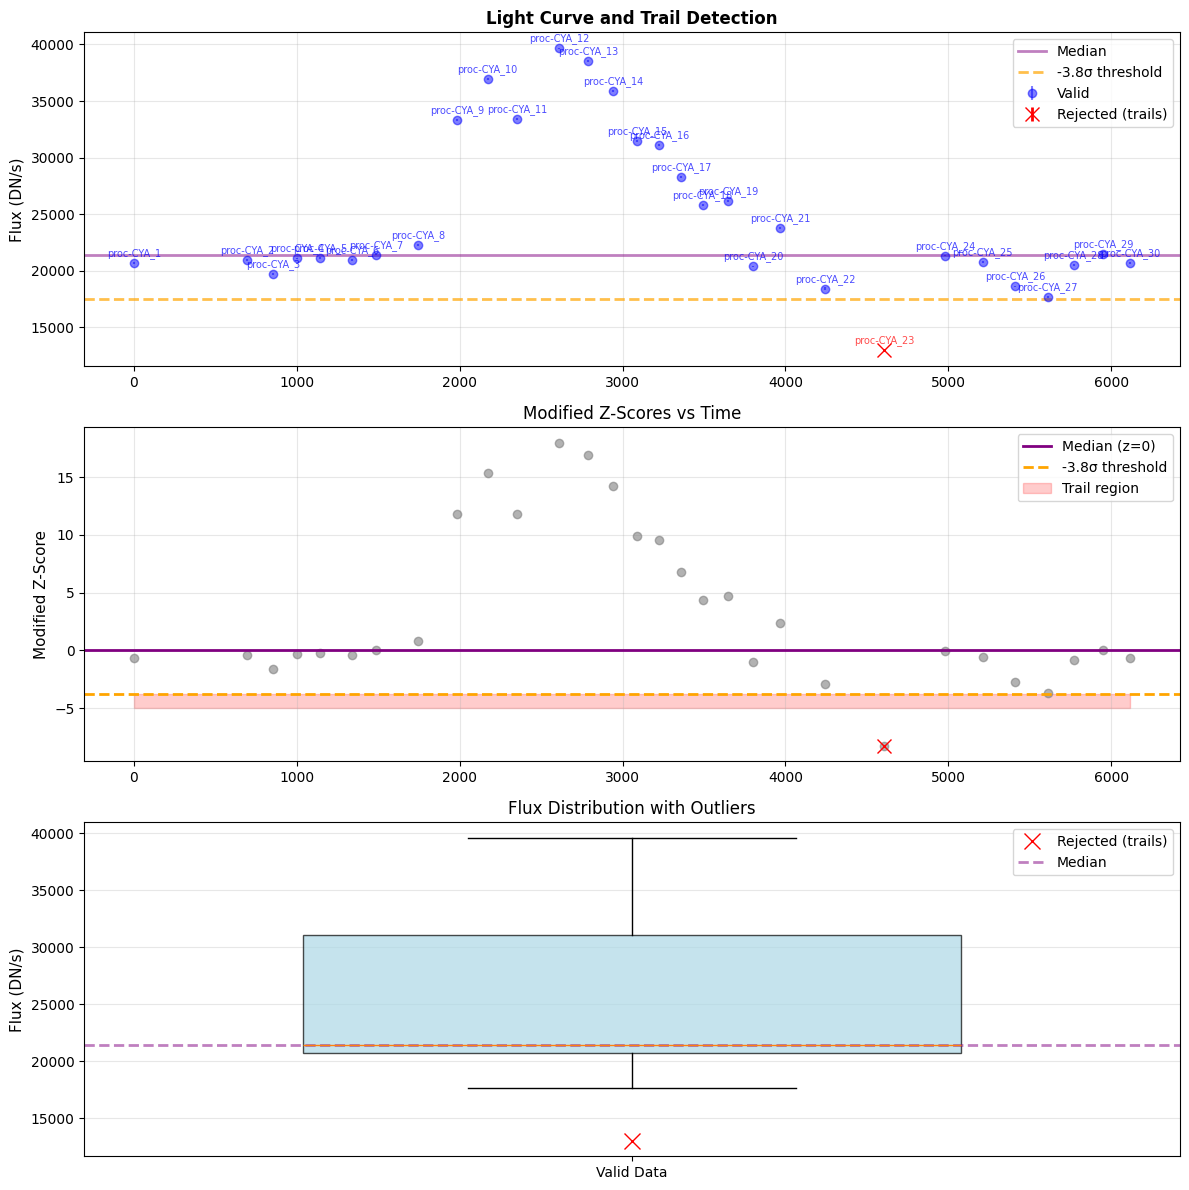

    TRAIL DETECTED in proc-CYA_R23.FIT:
      Measured flux: 12988.9 DN/s
      Median flux: 21386.9 DN/s
      Modified Z-Score: -8.28
      Time: 4607.0 s

SUMMARY: Found 1 trails, 29 good images
Excluded images: ['proc-CYA_R23.FIT']


In [19]:
# Detect trails in V-band images with plot
print("\nChecking V-band images for star trails...")
valid_V_idx = detect_trails(
    proc_targV_files, targV_xys, F_V_targ, F_V_targ_err, t_offs_V,
    outlier_threshold=3.8, plot=True
)

# Detect trails in R-band images with plot
print("\nChecking R-band images for star trails...")
valid_R_idx = detect_trails(
    proc_targR_files, targR_xys, F_R_targ, F_R_targ_err, t_offs_R,
    outlier_threshold=3.8, plot=True
)

# Filter the data
proc_targV_files = [proc_targV_files[i] for i in valid_V_idx]
proc_targR_files = [proc_targR_files[i] for i in valid_R_idx]
targV_xys = [targV_xys[i] for i in valid_V_idx]
targR_xys = [targR_xys[i] for i in valid_R_idx]
t_offs_V = t_offs_V[valid_V_idx]
t_offs_R = t_offs_R[valid_R_idx]
F_V_targ = F_V_targ[valid_V_idx]
F_V_targ_err = F_V_targ_err[valid_V_idx]
F_R_targ = F_R_targ[valid_R_idx]
F_R_targ_err = F_R_targ_err[valid_R_idx]

In [20]:
# Print full lists of fluxes and errors
print("Fluxes in V-band:")
for f, e in zip(F_V_targ, F_V_targ_err):
    print(f"  {f:.2f} ± {e:.2f}")

print("Fluxes in R-band:")
for f, e in zip(F_R_targ, F_R_targ_err):
    print(f"  {f:.2f} ± {e:.2f}")

Fluxes in V-band:
  9552.61 ± 51.94
  10801.06 ± 53.13
  10753.95 ± 53.23
  11031.91 ± 54.23
  10955.72 ± 54.36
  10236.81 ± 54.01
  10765.82 ± 54.14
  16221.88 ± 58.44
  19913.51 ± 61.83
  24473.86 ± 65.10
  25000.47 ± 65.61
  23587.97 ± 65.00
  22822.45 ± 64.52
  20272.80 ± 62.74
  17840.08 ± 61.37
  15849.45 ± 60.77
  13129.14 ± 59.07
  11758.33 ± 57.30
  13639.22 ± 58.71
  11638.93 ± 62.20
  10992.73 ± 67.47
  8795.31 ± 56.21
  9341.45 ± 56.69
  10646.91 ± 57.90
  10265.04 ± 57.50
  10760.16 ± 57.95
  11050.61 ± 57.37
  9856.30 ± 57.02
Fluxes in R-band:
  20716.13 ± 71.97
  20969.29 ± 71.53
  19715.55 ± 70.79
  21102.97 ± 72.67
  21144.17 ± 72.76
  20982.41 ± 72.90
  21427.50 ± 72.96
  22255.15 ± 74.43
  33343.53 ± 79.96
  36928.37 ± 82.74
  33385.12 ± 80.98
  39644.94 ± 84.32
  38558.93 ± 84.04
  35853.92 ± 82.95
  31468.26 ± 80.22
  31091.31 ± 80.10
  28271.25 ± 79.20
  25824.45 ± 77.34
  26157.66 ± 78.10
  20387.01 ± 74.13
  23776.91 ± 76.47
  18425.42 ± 150.14
  21346.36 ± 79.8

Now we'll use this observed flux level and the known magnitude to get a zero point (and associated uncertainty).

In [21]:
# Known magnitudes for the standard star
m_std_V = 9.239  # [mag] 
m_std_R = m_std_V - 0.800  # [mag] 

# Calculate zero points using: m0 = m_standard + 2.5 * log10(F)
# where F is the observed flux in DN/s
m0_V = m_std_V + 2.5 * np.log10(F0_V)  # [mag]
m0_R = m_std_R + 2.5 * np.log10(F0_R)  # [mag]

# Calculate uncertainties using error propagation
# For m = m0 + 2.5*log10(F), dm/dF = 2.5 / (F * ln(10))
# So: sigma_m = |2.5 / (F * ln(10))| * sigma_F
m0_V_err = 2.5 / (F0_V * np.log(10)) * F0_V_err  # [mag]
m0_R_err = 2.5 / (F0_R * np.log(10)) * F0_R_err  # [mag]

print(f"Zero point V-band: {m0_V:.3f} ± {m0_V_err:.3f} mag")
print(f"Zero point R-band: {m0_R:.3f} ± {m0_R_err:.3f} mag")

Zero point V-band: 19.944 ± 0.027 mag
Zero point R-band: 21.157 ± 0.007 mag


Finally we can use these to calibrate our target star photometry.

In [22]:
# calibrated target star V-band photometry [mag] with uncertainty
m_V_targ = m0_V - 2.5 * np.log10(F_V_targ)  # [mag]

# Propagate uncertainties: sigma_m^2 = sigma_m0^2 + (2.5/(F*ln(10)))^2 * sigma_F^2
m_V_targ_err = np.sqrt(m0_V_err**2 + (2.5 / (F_V_targ * np.log(10)) * F_V_targ_err)**2)  # [mag]

# calibrated target star R-band photometry [mag] with uncertainty
m_R_targ = m0_R - 2.5 * np.log10(F_R_targ)  # [mag]

# Propagate uncertainties
m_R_targ_err = np.sqrt(m0_R_err**2 + (2.5 / (F_R_targ * np.log(10)) * F_R_targ_err)**2)  # [mag]

print(f"Target star V-band magnitudes: {m_V_targ.mean():.3f} ± {m_V_targ_err.mean():.3f} mag (mean)")
print(f"Target star R-band magnitudes: {m_R_targ.mean():.3f} ± {m_R_targ_err.mean():.3f} mag (mean)")

# Print all V-band measurements
print("\n" + "="*70)
print("V-BAND MEASUREMENTS")
print("="*70)
print(f"{'#':<4} {'Filename':<20} {'Time [s]':<12} {'Mag':<10} {'Error':<10}")
print("-"*70)
for i, (fn, t, m, m_err) in enumerate(zip(proc_targV_files, t_offs_V, m_V_targ, m_V_targ_err)):
    print(f"{i+1:<4} {fn:<20} {t:<12.1f} {m:<10.4f} {m_err:<10.4f}")

# Print all R-band measurements
print("\n" + "="*70)
print("R-BAND MEASUREMENTS")
print("="*70)
print(f"{'#':<4} {'Filename':<20} {'Time [s]':<12} {'Mag':<10} {'Error':<10}")
print("-"*70)
for i, (fn, t, m, m_err) in enumerate(zip(proc_targR_files, t_offs_R, m_R_targ, m_R_targ_err)):
    print(f"{i+1:<4} {fn:<20} {t:<12.1f} {m:<10.4f} {m_err:<10.4f}")

print("\n" + "="*70)
print(f"V-band: {len(m_V_targ)} measurements, mean = {m_V_targ.mean():.4f} ± {m_V_targ_err.mean():.4f} mag")
print(f"R-band: {len(m_R_targ)} measurements, mean = {m_R_targ.mean():.4f} ± {m_R_targ_err.mean():.4f} mag")
print("="*70)

Target star V-band magnitudes: 9.640 ± 0.028 mag (mean)
Target star R-band magnitudes: 10.184 ± 0.008 mag (mean)

V-BAND MEASUREMENTS
#    Filename             Time [s]     Mag        Error     
----------------------------------------------------------------------
1    proc-CYA_V1.FIT      0.0          9.9938     0.0281    
2    proc-CYA_V2.FIT      675.0        9.8605     0.0280    
3    proc-CYA_V3.FIT      817.0        9.8652     0.0280    
4    proc-CYA_V4.FIT      965.0        9.8375     0.0280    
5    proc-CYA_V5.FIT      1150.0       9.8450     0.0280    
6    proc-CYA_V6.FIT      1305.0       9.9187     0.0280    
7    proc-CYA_V7.FIT      1520.0       9.8640     0.0280    
8    proc-CYA_V8.FIT      1774.0       9.4189     0.0277    
9    proc-CYA_V9.FIT      1974.0       9.1963     0.0277    
10   proc-CYA_V10.FIT     2161.0       8.9724     0.0276    
11   proc-CYA_V11.FIT     2361.0       8.9493     0.0276    
12   proc-CYA_V12.FIT     2598.0       9.0124     0.0276    
13

#### Plotting the calibrated photometry

We'll want to plot our photometry (and errors) vs. time.

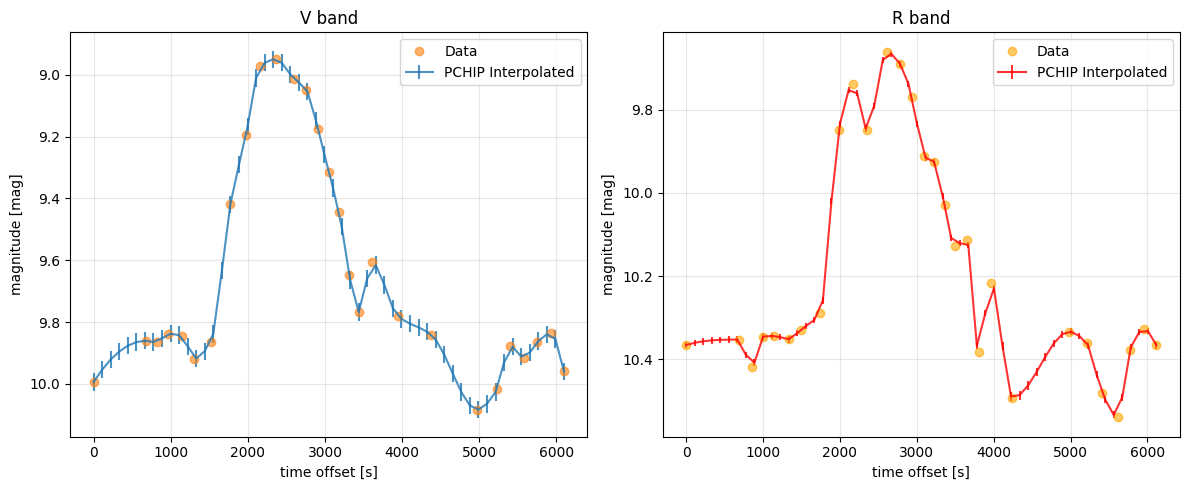

V-band: Interpolated 28 data points to 56 even points
R-band: Interpolated 29 data points to 56 even points


In [23]:
# Define even time steps for interpolation
n_points = 56  # number of evenly spaced points
t_V_even = np.linspace(min(t_offs_V), max(t_offs_V), n_points)
t_R_even = np.linspace(min(t_offs_R), max(t_offs_R), n_points)

# Interpolate magnitudes using PCHIP (Piecewise Cubic Hermite Interpolating Polynomial)
# PCHIP preserves monotonicity and avoids oscillations/overshoots
interp_V = PchipInterpolator(t_offs_V, m_V_targ)
interp_R = PchipInterpolator(t_offs_R, m_R_targ)

# Interpolate errors using linear (errors don't need smooth curves)
interp_V_err = interp1d(t_offs_V, m_V_targ_err, kind='linear')
interp_R_err = interp1d(t_offs_R, m_R_targ_err, kind='linear')

# Generate interpolated values
m_V_interp = interp_V(t_V_even)
m_V_err_interp = interp_V_err(t_V_even)
m_R_interp = interp_R(t_R_even)
m_R_err_interp = interp_R_err(t_R_even)

# Set up figure
fig = pylab.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Plot V band magnitudes (interpolated)
ax1.errorbar(t_V_even, m_V_interp, m_V_err_interp, fmt='-', 
            label='PCHIP Interpolated', alpha=0.8)
ax1.plot(t_offs_V, m_V_targ, 'o', label='Data', alpha=0.6)
ax1.set_title('V band')
ax1.set_xlabel('time offset [s]')
ax1.set_ylabel('magnitude [mag]')
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot R band magnitudes (interpolated)
ax2.errorbar(t_R_even, m_R_interp, m_R_err_interp, fmt='-', 
            color='red', label='PCHIP Interpolated', alpha=0.8)
ax2.plot(t_offs_R, m_R_targ, 'o', color='orange', label='Data', alpha=0.6)
ax2.set_title('R band')
ax2.set_xlabel('time offset [s]')
ax2.set_ylabel('magnitude [mag]')
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3)
ax2.legend()

# Finalize plot
pylab.tight_layout()
pylab.show()

print(f"V-band: Interpolated {len(t_offs_V)} data points to {n_points} even points")
print(f"R-band: Interpolated {len(t_offs_R)} data points to {n_points} even points")

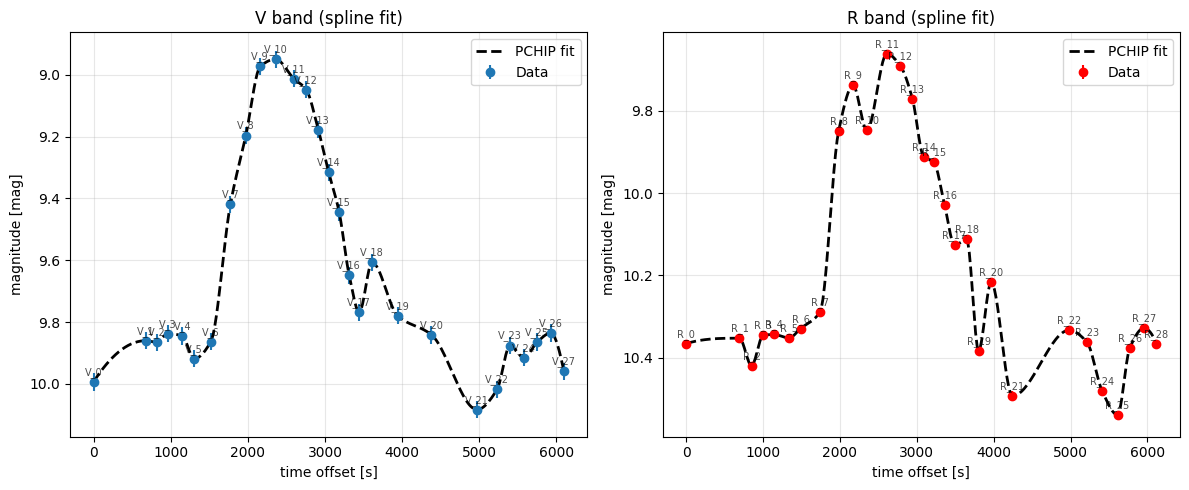

In [24]:
spl_V = PchipInterpolator(t_offs_V, m_V_targ)
spl_R = PchipInterpolator(t_offs_R, m_R_targ)

# Evaluate spline on even time grid
t_V_fit = np.linspace(min(t_offs_V), max(t_offs_V), 300)
t_R_fit = np.linspace(min(t_offs_R), max(t_offs_R), 300)
m_V_spline = spl_V(t_V_fit)
m_R_spline = spl_R(t_R_fit)

# Calculate residuals
residuals_V = m_V_targ - spl_V(t_offs_V)
residuals_R = m_R_targ - spl_R(t_offs_R)

# Plot results
fig = pylab.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# V-band
ax1.errorbar(t_offs_V, m_V_targ, m_V_targ_err, fmt='o', label='Data')
ax1.plot(t_V_fit, m_V_spline, '--', color='black', linewidth=2, label='PCHIP fit')
# Add index labels
for i in range(len(t_offs_V)):
    ax1.annotate(f'V_{i}', (t_offs_V[i], m_V_targ[i]), 
                textcoords="offset points", xytext=(0,5), ha='center', 
                fontsize=7, alpha=0.7)
ax1.set_title('V band (spline fit)')
ax1.set_xlabel('time offset [s]')
ax1.set_ylabel('magnitude [mag]')
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3)
ax1.legend()

# R-band
ax2.errorbar(t_offs_R, m_R_targ, m_R_targ_err, fmt='o', color='red', label='Data')
ax2.plot(t_R_fit, m_R_spline, '--', color='black', linewidth=2, label='PCHIP fit')
# Add index labels
for i in range(len(t_offs_R)):
    ax2.annotate(f'R_{i}', (t_offs_R[i], m_R_targ[i]), 
                textcoords="offset points", xytext=(0,5), ha='center', 
                fontsize=7, alpha=0.7)
ax2.set_title('R band (spline fit)')
ax2.set_xlabel('time offset [s]')
ax2.set_ylabel('magnitude [mag]')
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3)
ax2.legend()

pylab.tight_layout()
pylab.show()

#### Computing a color

We'll want to look at $V-R$ color vs. time as well.  One complication is that we don't have the same timestamps for our $V$ and $R$ exposures, so we can't just subtract them.

We can get a sense of the color change by interpolating the time sequences.


In [25]:
# Interpolate both bands to a common time grid
n_points = 56
t_common = np.linspace(max(min(t_V_even), min(t_R_even)), min(max(t_V_even), max(t_R_even)), n_points)

# Interpolate V and R onto the common grid
m_V_common = interp_V(t_common)
m_R_common = interp_R(t_common)
m_V_err_common = interp_V_err(t_common)
m_R_err_common = interp_R_err(t_common)

# Compute V-R color
color_VR = m_V_common - m_R_common

# Estimate uncertainties (quadrature sum)
color_VR_err = np.sqrt(m_V_err_common**2 + m_R_err_common**2)

#### Plotting the color
Let's see the results.

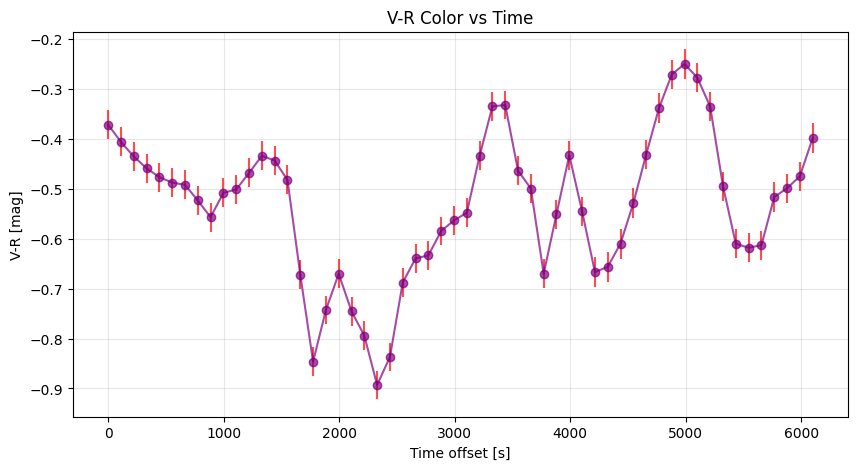

In [26]:
# Plot V-R color vs time
fig, ax = pylab.subplots(figsize=(10, 5))
ax.errorbar(t_common, color_VR, yerr=color_VR_err, fmt='o-', color='purple', ecolor='red', alpha=0.7)
ax.set_title('V-R Color vs Time')
ax.set_xlabel('Time offset [s]')
ax.set_ylabel('V-R [mag]')
ax.grid(True, alpha=0.3)
fig.savefig('color_time.pdf', dpi=600, bbox_inches='tight')
pylab.show()

In [27]:
print("Color plot values:")
for f, e in zip(color_VR, color_VR_err):
    print(f"  {f:.2f} ± {e:.2f}")

Color plot values:
  -0.37 ± 0.03
  -0.41 ± 0.03
  -0.44 ± 0.03
  -0.46 ± 0.03
  -0.48 ± 0.03
  -0.49 ± 0.03
  -0.49 ± 0.03
  -0.52 ± 0.03
  -0.56 ± 0.03
  -0.51 ± 0.03
  -0.50 ± 0.03
  -0.47 ± 0.03
  -0.43 ± 0.03
  -0.44 ± 0.03
  -0.48 ± 0.03
  -0.67 ± 0.03
  -0.85 ± 0.03
  -0.74 ± 0.03
  -0.67 ± 0.03
  -0.75 ± 0.03
  -0.79 ± 0.03
  -0.89 ± 0.03
  -0.84 ± 0.03
  -0.69 ± 0.03
  -0.64 ± 0.03
  -0.63 ± 0.03
  -0.58 ± 0.03
  -0.56 ± 0.03
  -0.55 ± 0.03
  -0.43 ± 0.03
  -0.34 ± 0.03
  -0.33 ± 0.03
  -0.46 ± 0.03
  -0.50 ± 0.03
  -0.67 ± 0.03
  -0.55 ± 0.03
  -0.43 ± 0.03
  -0.55 ± 0.03
  -0.67 ± 0.03
  -0.66 ± 0.03
  -0.61 ± 0.03
  -0.53 ± 0.03
  -0.43 ± 0.03
  -0.34 ± 0.03
  -0.27 ± 0.03
  -0.25 ± 0.03
  -0.28 ± 0.03
  -0.34 ± 0.03
  -0.50 ± 0.03
  -0.61 ± 0.03
  -0.62 ± 0.03
  -0.61 ± 0.03
  -0.52 ± 0.03
  -0.50 ± 0.03
  -0.48 ± 0.03
  -0.40 ± 0.03


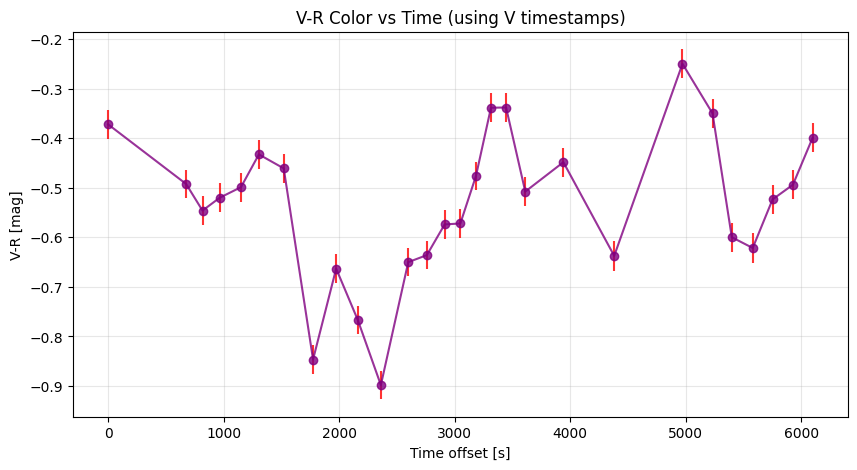

In [28]:
# Interpolate R to V-band timestamps
m_R_at_V = interp_R(t_offs_V)        # R magnitudes at V observation times
m_R_err_at_V = interp_R_err(t_offs_V)  # R errors interpolated to V times

# Compute V-R color
color_VR = m_V_targ - m_R_at_V

# Estimate uncertainties using quadrature sum
color_VR_err = np.sqrt(m_V_targ_err**2 + m_R_err_at_V**2)

# Plot V-R color vs V-band time
fig, ax = pylab.subplots(figsize=(10, 5))
ax.errorbar(t_offs_V, color_VR, yerr=color_VR_err, fmt='o-', color='purple', ecolor='r', alpha=0.8)
ax.set_title('V-R Color vs Time (using V timestamps)')
ax.set_xlabel('Time offset [s]')
ax.set_ylabel('V-R [mag]')
ax.grid(True, alpha=0.3)
pylab.show()